In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *
import pandas as pd

### The Pendulum Equation is given by:

$ \dot{x_1} = x_2$

$ \dot{x_2} = - a^2 \sin x_1 $

### and the Hamiltonian is given by:

$ H = \frac{x_2^2}{2}-\cos x_1$

In [3]:
# define the system ODE

def pendulum(t,X,a):
    # define individual ODEs or rates of change
    dx1dt = X[1]
    dx2dt = -(a**2)*np.sin(X[0])
    # collect rates of change
    dXdt = np.asarray([dx1dt,dx2dt])
    # return the result
    return dXdt


# define the hamiltonian for the system
def Hamiltonian(X):
    
    x1 = X[0]; x2 = X[1]
    
    H = (x2**2)/2-np.cos(x1)
    
    return H

### Collect Trajectories

In [4]:
dt = 0.001 # time step
tspan = [0, 10] # initial and final time
t_vec = np.arange(0,10,dt) # time vector
x0 = [1, -1] # initial condition

a = 1 # parameter for the pendulum equation

states = solve_ivp(pendulum, tspan, x0, t_eval = t_vec , args = (a,))

t = states.t
X = states.y

Text(0.5, 1.0, 'Pendulum System State Evolution')

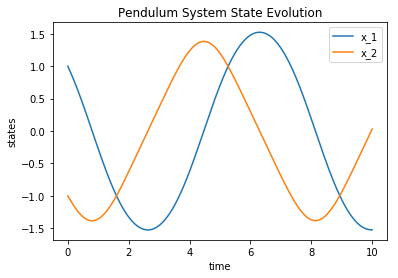

In [5]:
plt.plot(t,states.y[0,:],label = 'x_1')
plt.plot(t,states.y[1,:],label = 'x_2')
plt.legend()
plt.xlabel('time')
plt.ylabel('states')
plt.title('Pendulum System State Evolution')

### Identify Koopman Eigenfunction with Lambda = 0 (Hamiltonian) from Full Trajectory for Truth/Reference

In [6]:
Hamilt = [Hamiltonian(X[:,i]) for i in range(X.shape[1])]

### Compute Derivatives Using Fourth Order Central Difference

In [7]:
def fourth_order_dev(X):
    
    nstates = 2
    dX = np.zeros([nstates,X.shape[1]-4])

    for i in range(nstates):
        dX[i,:] = (1/(12*dt)) * (-X[i,4:] + 8*X[i,3:-1] - 8*X[i,1:-3] + X[i,:-4]) 
        
    X = X[:,2:-2]
    
    return X,dX

In [8]:
X,dX = fourth_order_dev(X)

### Build Theta

In [9]:
def buildTheta(yin,polyorder,usesine):
    
    n = yin.shape[1]
    nVars = yin.shape[0]
    
    # first entry for first order polynomial
    col = np.reshape(yin[0,:],(n,1))
    yout = col
    
    # first order polynomial
    for i in range(1,nVars):
        col = np.reshape(yin[i,:],(n,1))
        yout = np.append(yout,col,axis = 1)
       
    
    # second oder polynmial 
    if (polyorder >= 2):
        for i in range(nVars):
            for j in range(i,nVars):
                col = np.reshape(yin[i,:]*yin[j,:],(n,1))
                yout = np.append(yout,col,axis = 1)
    
    # third order polynomial
    if (polyorder >= 3):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    col = np.reshape(yin[i,:]*yin[j,:]*yin[k,:],(n,1))
                    yout = np.append(yout,col,axis = 1)
    
    # fourth order polynomial
    if (polyorder >= 4):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k,nVars):
                        col = np.reshape(yin[i,:]*yin[j,:]*yin[k,:]*yin[l,:],(n,1))
                        yout = np.append(yout,col,axis = 1)
    
    # sines
    if(usesine):
        for i in range(nVars):
            col = np.reshape(np.cos(yin[i,:]),(n,1))
            yout = np.append(yout,col,axis = 1)
                
                                 
    return yout

### Build Gamma

In [10]:
def buildGamma(yin,ydotin,polyorder,usesine):
    
    n = yin.shape[1]
    nVars = yin.shape[0]
    
    # first entry for first order polynomial
    col = np.reshape(ydotin[0,:],(n,1))
    yout = col
    # derivative of first order polynomial
    for i in range(1,nVars):
        col = np.reshape(ydotin[i,:],(n,1))
        yout = np.append(yout,col,axis = 1)
        
    # derivative of second order polynomial
    if (polyorder >= 2):
        for i in range(nVars):
            for j in range(i,nVars):
                col = np.reshape(ydotin[i,:]*yin[j,:]+yin[i,:]*ydotin[j,:],(n,1))
                yout = np.append(yout,col,axis = 1)
    
    # third order polynomial
    if (polyorder >= 3):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    col = (np.reshape(ydotin[i,:]*yin[j,:]*yin[k,:]+yin[i,:]*ydotin[j,:]*yin[k,:]
                                      +yin[i,:]*yin[j,:]*ydotin[k,:],(n,1)))
                    yout = np.append(yout,col,axis = 1)
                    
    # fourth order polynomial
    if (polyorder >= 4):
        for i in range(nVars):
            for j in range(i, nVars):
                for k in range(j, nVars):
                    for l in range(k,nVars):
                        col = (np.reshape(ydotin[i,:]*yin[j,:]*yin[k,:]*yin[l,:]
                                          +yin[i,:]*ydotin[j,:]*yin[k,:]*yin[l,:]
                                          +yin[i,:]*yin[j,:]*ydotin[k,:]*yin[l,:]
                                          +yin[i,:]*yin[j,:]*yin[k,:]*ydotin[l,:],(n,1)))
                        yout = np.append(yout,col,axis = 1)
    
    
    # sines
    if(usesine):
        for i in range(nVars):
            col = np.reshape(-np.sin(yin[i,:])*ydotin[i,:],(n,1))
            yout = np.append(yout,col,axis = 1)
                
    
    return yout


In [11]:
Theta = buildTheta(X,3,True)
Gamma = buildGamma(X,dX,3,True)

### Compute the Co-efficients Vector Using Different Methods

In [12]:
# Method 1 - SVD
lamda = 0.01
U,Sigma,VT = np.linalg.svd(lamda*Theta-Gamma,full_matrices=0)
V = VT.T

xi0 = V[:,-1]
thresh_xi0 = np.where(np.abs(xi0) < 1e-4)
xi0[thresh_xi0[0]] = 0

V_pd = pd.DataFrame(data = V)
V_pd.head(19)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.211438,0.151220,-0.084577,0.433027,-0.147515,0.217480,-0.017000,0.815526,0.048448,0.023777,-0.020468
1,0.128208,0.131291,0.078511,0.090088,0.482447,0.217832,-0.073992,-0.051948,0.814485,0.016427,0.003210
2,0.293811,0.329814,-0.542389,-0.096290,-0.059903,0.001472,-0.646738,-0.015776,-0.066683,0.254804,0.099800
3,-0.031827,-0.001146,0.109619,-0.499532,-0.280543,0.811607,-0.004770,0.001388,-0.001346,-0.000370,0.000263
4,-0.244409,-0.285505,0.443912,0.086582,0.057678,-0.000517,-0.667249,-0.023799,-0.064363,0.101676,-0.436580
5,-0.767254,0.507042,-0.122407,0.084987,0.041977,0.054573,0.004492,-0.355917,-0.020147,-0.009927,0.009011
6,-0.112024,-0.366183,-0.382726,0.072210,0.673809,0.323747,0.045562,0.019776,-0.374566,-0.008299,-0.001440
7,0.222032,-0.126163,-0.051660,0.714706,-0.308317,0.349618,0.013248,-0.450358,-0.026869,-0.012908,0.011528
8,0.340285,0.573241,0.483848,0.108601,0.328176,0.128529,0.034679,0.025908,-0.428398,-0.008705,-0.001943
9,-0.121910,-0.142126,0.221650,0.043340,0.028915,-0.000703,-0.330542,0.025633,-0.025630,-0.347896,0.825525


In [13]:
Sigma

array([247.03387394, 219.41830691, 174.24818009, 152.66456392,
       122.67416881, 107.82365367,   9.84288554,   5.18687952,
         4.3182945 ,   0.60092684,   0.28475759])

In [14]:
## Method 2 - LS
K = np.matmul(np.linalg.pinv(Theta),Gamma)
thresh_ind = np.where(np.abs(K) < 1e-12)
K[thresh_ind] = 0
[D,T] = np.linalg.eig(K)
IX = np.argsort(np.abs(D))

xi1 = T[:,IX[0]]
thresh_xi1 = np.where(np.abs(xi1) < 1e-4)
xi1 = np.real(xi1)
xi1[thresh_xi1[0]] = 0

In [15]:
np.abs(D)

array([4.24510152e+00, 4.24510152e+00, 2.57164869e+00, 2.57164869e+00,
       1.73622359e+00, 1.73622359e+00, 8.57063081e-01, 8.57063081e-01,
       7.88583480e-01, 7.88583480e-01, 6.55821495e-04])

In [16]:
# combine the co-efficients obtianed from the two different methods
xi = np.vstack([xi0,xi1]).T
xi_pd = pd.DataFrame(data = xi, columns = ['xi0 - SVD','xi1 - LS'])
xi_pd.head(19)

,xi0 - SVD,xi1 - LS
0,-0.020468,0.006728
1,0.003210,-0.009523
2,0.099800,-0.208702
3,0.000263,-0.000183
4,-0.436580,0.337763
5,0.009011,-0.002974
6,-0.001440,0.004508
7,0.011528,-0.003724
8,-0.001943,0.005108
9,0.825525,-0.572755


In [17]:
eigen_func1 = np.dot(Theta,xi0)
norm1 = np.linalg.norm(eigen_func1)
eigen_func1n = eigen_func1/norm1

eigen_func2 = np.dot(Theta,xi1)
norm2 = np.linalg.norm(eigen_func2)
eigen_func2n = eigen_func2/norm2

norm_hamil = np.linalg.norm(Hamilt[:X.shape[1]])
Hamil_normalized = Hamilt[:X.shape[1]]/norm_hamil


new_t = t[:X.shape[1]]

Text(0.5, 1.0, 'Un-normalized')

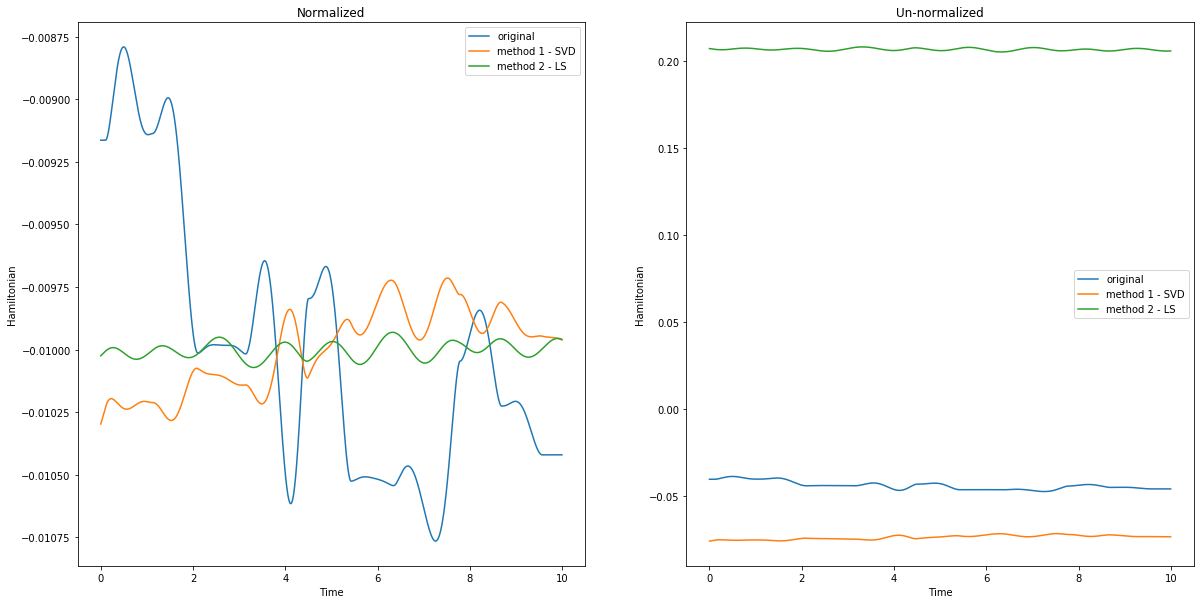

In [18]:
f = plt.figure(figsize=(20,10))

f.add_subplot(1,2,1)
plt.plot(new_t,Hamil_normalized, label = 'original')
plt.plot(new_t,eigen_func1n, label = 'method 1 - SVD')
plt.plot(new_t,-1*eigen_func2n, label = 'method 2 - LS')
plt.legend()
plt.ylabel('Hamiltonian')
plt.xlabel('Time')
plt.title('Normalized')

f.add_subplot(1,2,2)
plt.plot(new_t,Hamilt[:X.shape[1]], label = 'original')
plt.plot(new_t,eigen_func1, label = 'method 1 - SVD')
plt.plot(new_t,eigen_func2, label = 'method 2 - LS')
plt.legend()
plt.ylabel('Hamiltonian')
plt.xlabel('Time')
plt.title('Un-normalized')

In [20]:
forecast1 = np.dot(Gamma,xi0)